<img src="static/photo2map.jpg" width=700 align="center"/>

# Photo -> Map
Disclaimer: this notebook is an adopted version of [this repository](https://github.com/GunhoChoi/Kind-PyTorch-Tutorial).

Previously, we used neural networks for **sparse** predictions: large input (image) -> small output (vector with 10 elements, e.g. CIFAR10 classes). Today we'll use deep learning to make **dense** predictions (large input (image) -> large output (image)) for **image-to-image translation problem**. *Image-to-image translation* is a wide class of problems, where input is image and output is image too (e.g. satellite photo -> map, image stylization, [sketch -> cat portrait](https://affinelayer.com/pixsrv/),  etc...). There many good models for dense predictions, but we'll use **UNet** as the best choice in terms of simplicity-quality ratio.

But before we start, let's look at our dataset.

## Task 1 (1 point). Dataset
We'll dataset of pairs **satellite photo - map** (example is above). To download dataset, uncomment and run command below:

In [0]:
! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
! tar -xzvf maps.tar.gz
! mkdir maps/train/0 && mv maps/train/*.jpg maps/train/0
! mkdir maps/val/0 && mv maps/val/*.jpg maps/val/0

--2019-03-08 15:56:59--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  30.0MB/s    in 7.9s    

2019-03-08 15:57:08 (30.1 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/trai

Imports:

In [0]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms


Parameters:

In [0]:
experiment_title = "unet"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 4
image_size = 256

data_dir = "./maps"

transform = transforms.Compose([
    transforms.Resize(size=image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

After downloading and unpacking you'll find directory `maps` with 2 subdirectories: `train` and `val`. Each image is a pair (photo - map), so we'll have to **crop image to obtain input and target**. Let's use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) dataloader: 

In [0]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Draw sample from dataset:

In [0]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

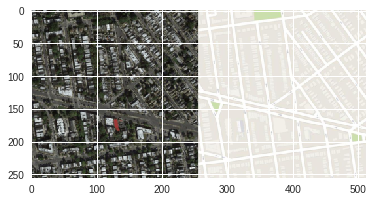

In [0]:
(image, _) = train_dataset[0]
imshow(image)

As we can see input and target are in the same image. Let's write wrapper of ImageFolder to return what we need:

In [0]:
class PhotoMapDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, _ = self.samples[index]
        sample = self.loader(path)
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        photo_image, map_image = torch.chunk(sample, 2, dim=-1)
        
        return photo_image, map_image

So now we have:

In [0]:
train_dataset = PhotoMapDataset(root=os.path.join(data_dir, "train"), transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

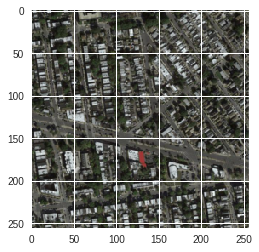

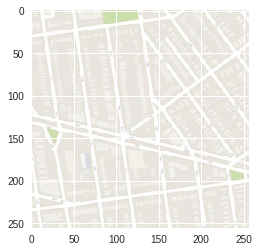

In [0]:
photo_image, map_image = train_dataset[0]
imshow(photo_image)
imshow(map_image)

Okay, we're don with data. Let's move to defining model.

## Task 2 (2 ponts). UNet
UNet is a very popular fully-convolutional architecture. Below you can find its sctructure (for more detatils refer to [original paper](https://arxiv.org/abs/1505.04597)):

<img src="static/unet.png" width=1000 align="center"/>

Let's build UNet!

In [0]:
class UnetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super().__init__()
        self.pooling = pooling
        kernel_size=3
        self.pooling = pooling
        
        self.net_down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=(kernel_size//2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=(kernel_size//2)),
            nn.ReLU(inplace=True)
        )

        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        x_before_pooling = self.net_down(x)
        x = self.pool(x_before_pooling) if self.pooling else x_before_pooling
         
        return x, x_before_pooling

In [0]:
x = torch.rand(5, 3, 256, 256)
l = nn.ConvTranspose2d(3, 3, 2, 2, 0)
l(x).shape

torch.Size([5, 3, 512, 512])

In [0]:
class UnetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
    
        self.net_up = nn.Sequential(
            nn.Conv2d(2 * out_channels, out_channels, 3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=1),
            nn.ReLU(inplace=True)
        )
        
        self.up_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x, x_bridge):
        x = self.up_conv(x)
        x = torch.cat([x_bridge, x], dim=1)
        x = self.net_up(x)
        
        return x

In [0]:
class Unet(nn.Module):
    def __init__(self, in_channels, out_channels, depth=3, base_n_filters=64):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.depth = depth
        self.base_n_filters = base_n_filters
        
        down_blocks = []
        for i in range(depth):
            current_in_channels = in_channels if i == 0 else current_out_channels
            current_out_channels = base_n_filters * (2 ** i)
            pooling = False if i == depth - 1 else True
            
            down_block = UnetDownBlock(current_in_channels, current_out_channels, pooling=pooling)
            down_blocks.append(down_block)
        
        up_blocks = []
        for i in range(depth - 1):
            current_in_channels = current_out_channels
            current_out_channels = current_in_channels // 2
            
            up_block = UnetUpBlock(current_in_channels, current_out_channels)
            up_blocks.append(up_block)
            
        self.down_blocks = nn.ModuleList(down_blocks)
        self.up_blocks = nn.ModuleList(up_blocks)
        
        self.conv_final = nn.Conv2d(current_out_channels, out_channels, kernel_size=(1, 1), stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x_bridges = []
        for i in range(self.depth):
            x, x_bridge = self.down_blocks[i](x)
            if i != self.depth - 1:
                x_bridges.append(x_bridge)
        
        for i in range(self.depth - 1):
            x = self.up_blocks[i](x, x_bridges[-i - 1])
        
        x = self.conv_final(x)
        x = self.sigmoid(x)
        return x
    
    def __repr__(self):
        message = '{}(in_channels={}, out_channels={}, depth={}, base_n_filters={})'.format(
            self.__class__.__name__,
            self.in_channels, self.out_channels, self.depth, self.base_n_filters
        )
        return message

In [0]:
model = Unet(3, 3, depth=4, base_n_filters=64).to(device)
model

Unet(in_channels=3, out_channels=3, depth=4, base_n_filters=64)

## Train-loop

Optimization setup:

In [0]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0002)

TensorboardX setup:

In [0]:
!pip3 install tensorboardx

    100% |████████████████████████████████| 133kB 4.5MB/s 


In [0]:
from tensorboardX import SummaryWriter
from datetime import datetime

experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

In [0]:
experiment_name

'unet@08.03.2019-16:01:39'

In [0]:
writer = SummaryWriter(log_dir=os.path.join("tb",experiment_name))

Train-loop:

In [0]:
n_epochs = 5
n_iters_total = 0

for epoch in range(n_epochs):
    for batch in tqdm(train_dataloader):
        # unpack batch
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        
        # forward
        map_image_pred_batch = model(photo_image_batch)
        loss = criterion(map_image_pred_batch, map_image_batch)
        
        # optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        
        if n_iters_total % 50 == 0:
            writer.add_image('train/photo_image', torchvision.utils.make_grid(photo_image_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_gt', torchvision.utils.make_grid(map_image_batch, normalize=True, scale_each=True), n_iters_total)
        
        n_iters_total += 1
        
    print("Epoch {} done.".format(epoch))


Epoch 0 done.



Epoch 1 done.



Epoch 2 done.



Epoch 3 done.



Epoch 4 done.


## Run tensorboard

To look at your logs in tensorboard go to terminal and run command:
```bash
$ tensorboard --logdir PATH_TO_YOUR_LOG_DIR
```

Then go to browser to `localhost:6006` and you'll see beautiful graphs! Always use tensorbord to watch your experiment, because it's very important to check how training is going on.

## Task 3 (1 point). Validation

As you remember we have `val` images in our dataset. So, to make sure, that we didn't overfit to `train`, we should do evaluation on validation set. You're free to choose, how to insert validation in existing notebook:
1. Insert validation to train-loop (validate every epoch)
2. Validate 1 time after training

I highly recomend to implement first option with beautiful tensorboard logs. Have fun! :)

In [0]:
val_dataset = PhotoMapDataset(root=os.path.join(data_dir, "val"), transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Обучаем, но уже с валидацией

In [0]:
model = Unet(3, 3, depth=4, base_n_filters=64).to(device)
model

Unet(in_channels=3, out_channels=3, depth=4, base_n_filters=64)

In [0]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0002)

In [0]:
experiment_name = "{}@{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
writer = SummaryWriter(log_dir=os.path.join("./tb", experiment_name))

In [32]:
n_epochs = 5
n_iters_total = 0
n_iters_total_val = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
  
    for batch in tqdm(train_dataloader):
        # unpack batch
        photo_image_batch, map_image_batch = batch
        photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
        
        # forward
        map_image_pred_batch = model(photo_image_batch)
        loss = criterion(map_image_pred_batch, map_image_batch)
        
        # optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        
        if n_iters_total % 50 == 0:
            writer.add_image('train/photo_image', torchvision.utils.make_grid(photo_image_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch, normalize=True, scale_each=True), n_iters_total)
            writer.add_image('train/map_image_gt', torchvision.utils.make_grid(map_image_batch, normalize=True, scale_each=True), n_iters_total)
        
        n_iters_total += 1
        
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            # unpack batch
            photo_image_batch, map_image_batch = batch
            photo_image_batch, map_image_batch = photo_image_batch.to(device), map_image_batch.to(device)
            
            # forward
            map_image_pred_batch = model(photo_image_batch)
            loss = criterion(map_image_pred_batch, map_image_batch)
            
            running_val_loss += loss.item()
            
            # dump statistics
            writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
        
            if n_iters_total_val % 50 == 0:
                writer.add_image('val/photo_image', torchvision.utils.make_grid(photo_image_batch, normalize=True, scale_each=True), n_iters_total_val)
                writer.add_image('val/map_image_pred', torchvision.utils.make_grid(map_image_pred_batch, normalize=True, scale_each=True), n_iters_total_val)
                writer.add_image('val/map_image_gt', torchvision.utils.make_grid(map_image_batch, normalize=True, scale_each=True), n_iters_total_val)
        
            n_iters_total_val += 1
        
    print("[epoch {}] loss: {:.3} val loss: {:.3}".format(epoch, running_loss / len(train_dataloader), running_val_loss / len(val_dataloader)))
      
        
#     print("Epoch {} done.".format(epoch))

[epoch 0] loss: 0.0378 val loss: 0.0189


[epoch 1] loss: 0.028 val loss: 0.0168


[epoch 2] loss: 0.0253 val loss: 0.015


[epoch 3] loss: 0.0235 val loss: 0.0162


[epoch 4] loss: 0.0226 val loss: 0.0145
